<a href="https://colab.research.google.com/github/kazelouis/sxuxin/blob/main/Tut_3b_Transfer_Learning_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial 3b - Transfer Learning

## Transfer Learning

Typically we do not train an entire Convolutional Neural Networks from scratch. One reason is that it is rare to have access to enough data to train the networks sufficiently. The other reason, as we have seen in labs 2 and 3, training neural networks can take a long time even on small 32 x 32 pixel images. Extending this to larger images such as the 3 x 224 x 224 that are commonly found in the ImageNet dataset could take weeks on a single GPUs.

Instead, we can use pretrained networks such as the AlexNet, or VGG as feature extractors and train a smaller fully connected ANN to do our final classifications.

## AlexNet in PyTorch

Convolutional networks are very commonly used, meaning that there are often alternatives to
training convolutional networks from scratch. In particular, researchers often release both
the architecture and **the weights** of the networks they train.

As an example, let's look at the AlexNet model, whose trained weights are included in `torchvision`.
AlexNet was trained to classify images into one of many categories.
The AlexNet can be imported and used as shown below.

In [1]:
# alexnet
import torchvision.models

alexNet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 56.1MB/s]


In [2]:
alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Notice that the AlexNet model is split into two parts. There is a component that computes
"features" using convolutions.

In [3]:
alexNet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

There is also a component that classifies the image based on the computed features.

In [4]:
alexNet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### AlexNet Features

The first network can be used independently of the second. Specifically, it can be used
to compute a set of **features** that can be used later on. This idea of using neural
network activation *features* to represent images is an extremely important one, so it
is important to understand the idea now.

To see how we can do this, let's first load an image.

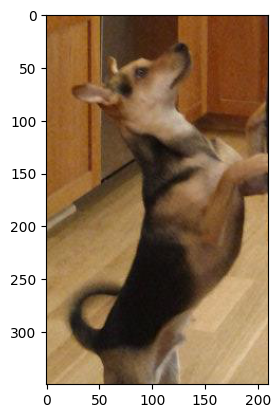

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import urllib

#load colour image
url ="https://drive.google.com/uc?export=view&id=1oaLVR2hr1_qzpKQ47i9rVUIklwbDcews"
img = np.array(PIL.Image.open(urllib.request.urlopen(url)))

img = img[:,:,:3]
plt.imshow(img)

To use this image we need to convert it into a PyTorch tensor of the appropriate shape.

In [6]:
import torch

#convert to tensor
x = torch.from_numpy(img) # turn img into a PyTorch tensor
print(x.shape)

x = x.permute(2,0,1)      # move the channel dimension to the beginning
#first is channels, but tensors have channel at the end, so move element 2 to 0
print(x.shape)

torch.Size([350, 210, 3])
torch.Size([3, 350, 210])


Next, we feed the image x as an input to our alexNet feature network.

In [21]:
import torch

#features = alexNet.features(x)
#features.shape
#missing batch size, so throw error, need another parameter

**This results in an error!** Even when our batch size is 1, we still need the batch size dimension to be set to 1, so that the input
follows the "NCHW" format (N = batch size, C = channels, H = height, W = width)

In [22]:
x = x.reshape([1, 3, 350, 210]) # add a dimension for batching
print(x.shape)

torch.Size([1, 3, 350, 210])


In [23]:
import torch
x = x.float()

features = alexNet.features(x)
features.shape
#batch size=1, output channels=256, 9x5 is dimension of output

torch.Size([1, 256, 9, 5])

The set of numbers in `features` is another way of representing our image `x`. Recall that
our initial image `x` was also represented as a tensor, also a set of numbers representing
pixel intensity. Geometrically speaking, we are using points in a high-dimensional space to
represent the images. in our pixel representation, the axes in this high-dimensional space
were different pixels. In our `features` representation, the axes are not as easily
interpretable.

But we will want to work with the `features` representation, because this representation
makes classification easier. This representation organizes images in a more "useful" and
"semantic" way than pixels.

Let me be more specific:
this set of `features` was trained on image classification. It turns out that
**these features can be useful for performing other image-related tasks as well!**
That is, if we want to perform an image classification task of our own (for example,
classifying cancer biopsies, which is nothing like what AlexNet was trained to do),
we might compute these AlexNet features, and then train a small model on top of those
features. We replace the `classifier` portion of `AlexNet`, but keep its `features`
portion intact.

Somehow, through being trained on one type of image classification problem, AlexNet
learned something general about representing images for the purposes of other
classification tasks.

### AlexNet First Convolutions

Here is the first convolution of AlexNet, applied to our image.

In [ ]:
alexNetConv = alexNet.features[0]
y = alexNetConv(x)
#output size of first convolution layer
y.shape
#batchsize=1, 64 channels, 86x51 is output dimension

torch.Size([1, 64, 86, 51])

The output is a $1 \times 64 \times 86 \times 51$ tensor.

In [ ]:
y = y.detach().numpy()
y = (y - y.min()) / (y.max() - y.min())
y.shape

(1, 64, 86, 51)

We can visualize each channel independently.

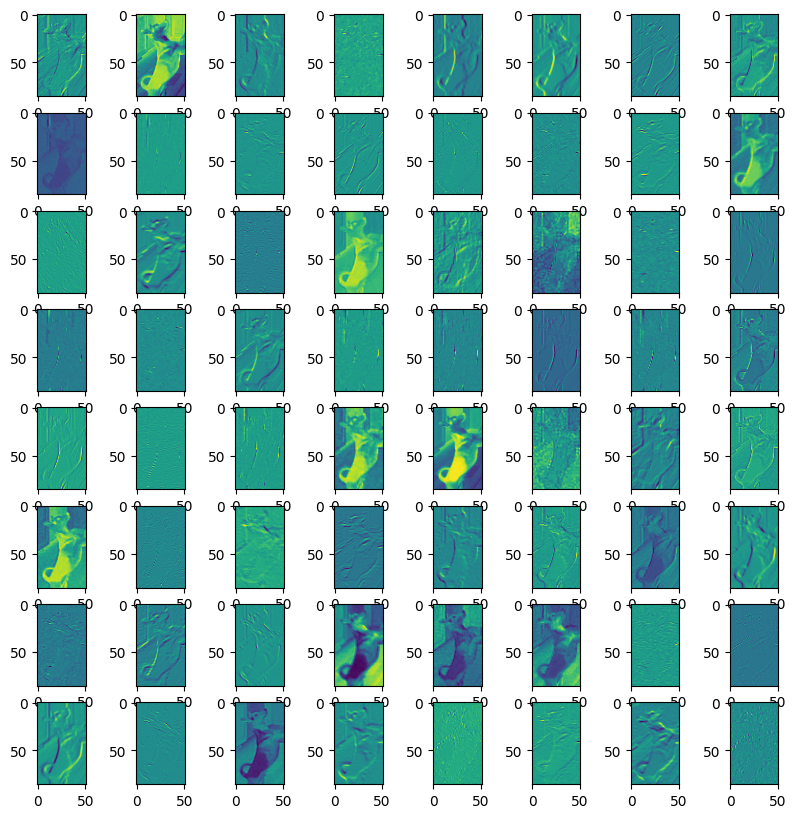

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(y[0, i])

What happens to the output if we try to use other images? Specifically, what happens to the size of the feature tensor when you use a cat image vs. a dog image? What changes? What stays the same?

## Applying AlexNet on a Dataset
In order to use transfer learning with AlexNet on a new dataset we will have to keep in mind how AlexNet was trained. AlexNet was trained on images of 3 x 224 x 224 images from the ImageNet dataset. These images are of higher resolution than what we have seen until now and are in colour. Hence, it would take significant effort to apply AlexNet to MNIST data, instead we will use another dataset.

### Data Loading from a File
To load our data we will use PyTorch's ImageFolder class which makes things a lot easier by allowing you to load data from a directory. For example, the training images are all stored in a directory path that looks like this:

/datadir

    /train  
        /class1  
        /class2  
        .  
        .  
    /val  
        /class1  
        /class2  
        .  
        .  
    /test  
        /class1  
        /class2  
        .  
        .  

You will need to mount your Google Drive to make this work with Colab.

**It is important to copy the dataset in the host's local storage (e.g., unzip in `/root/datasets`)**

In [7]:
#mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
!unzip '/content/drive/MyDrive/APS360/Tutorial3/Flower_Data_Large.zip' -d '/root/datasets/'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/Flower_Data_Large/train/daisy/4318007511_e9f4311936_n.jpg  
  inflating: /root/datasets/__MACOSX/Flower_Data_Large/train/daisy/._4318007511_e9f4311936_n.jpg  
  inflating: /root/datasets/Flower_Data_Large/train/daisy/520752848_4b87fb91a4.jpg  
  inflating: /root/datasets/__MACOSX/Flower_Data_Large/train/daisy/._520752848_4b87fb91a4.jpg  
  inflating: /root/datasets/Flower_Data_Large/train/daisy/147068564_32bb4350cc.jpg  
  inflating: /root/datasets/__MACOSX/Flower_Data_Large/train/daisy/._147068564_32bb4350cc.jpg  
  inflating: /root/datasets/Flower_Data_Large/train/daisy/6148728633_27afc47b0c_m.jpg  
  inflating: /root/datasets/__MACOSX/Flower_Data_Large/train/daisy/._6148728633_27afc47b0c_m.jpg  
  inflating: /root/datasets/Flower_Data_Large/train/daisy/5135131051_102d4878ca_n.jpg  
  inflating: /root/datasets/__MACOSX/Flower_Data_Large/train/daisy/._5135131051_102d4878ca_n.jpg  
  inflating: /root/dataset

If you have not uploaded the dataset to your google drive use this method.

In [ ]:
! pip install wget

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=17OHzIaYhbiFwwg3EzN97OaNN-ibqe7wH&confirm=yes' -O Flower_Data_Large.zip


In [ ]:
!unzip 'Flower_Data_Large.zip' -d '/root/datasets'


In [13]:
import time
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [32]:
# define training and test data directories
data_dir = '/root/datasets/Flower_Data_Large'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [35]:
# load and transform data using ImageFolder

# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))

Num training images:  3039
Num validation images:  540


In [36]:
# define dataloader parameters
batch_size  = 256
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

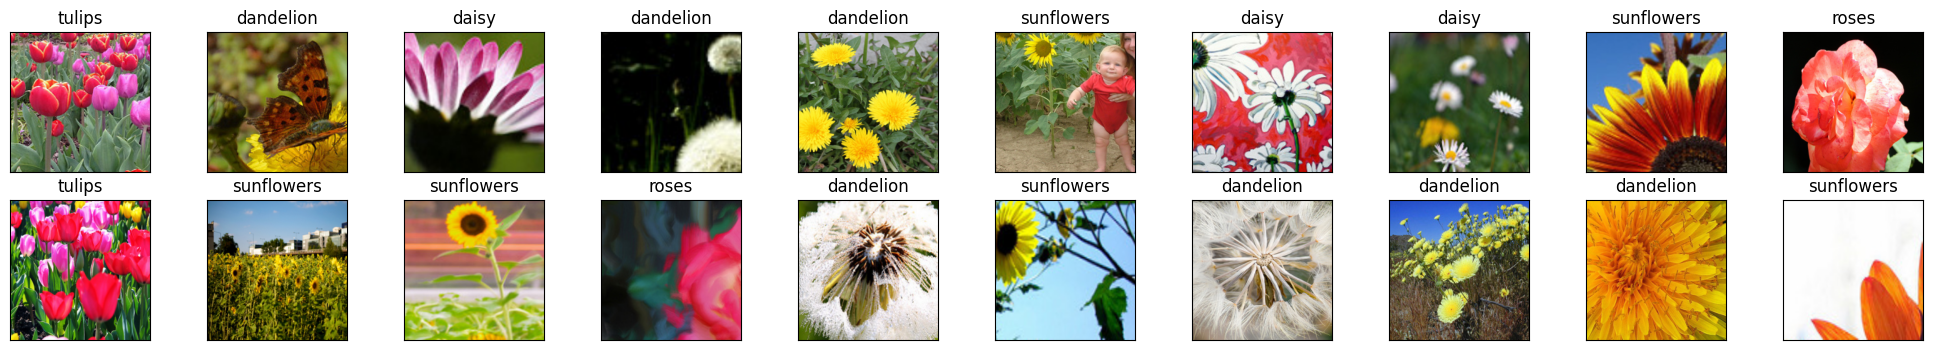

In [37]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### AlexNet Implementation

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

# alexnet
import torchvision.models

torch.manual_seed(1) # set the random seed

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
features.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([256, 256, 6, 6])

In [39]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 5)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [40]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(ALNC(imgs))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [45]:
def train(model, data, batch_size=20, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####

            out = model(ALNC(imgs))             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


In [42]:
!nvidia-smi

Fri Feb 16 21:35:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   8.33  % Time Elapsed:   4.29 s 
Iteration:  2 Progress:  16.67  % Time Elapsed:   8.16 s 
Iteration:  3 Progress:  25.00  % Time Elapsed:  11.23 s 
Iteration:  4 Progress:  33.33  % Time Elapsed:  14.25 s 
Iteration:  5 Progress:  41.67  % Time Elapsed:  17.20 s 
Iteration:  6 Progress:  50.00  % Time Elapsed:  20.98 s 
Iteration:  7 Progress:  58.33  % Time Elapsed:  24.13 s 
Iteration:  8 Progress:  66.67  % Time Elapsed:  27.22 s 
Iteration:  9 Progress:  75.00  % Time Elapsed:  30.22 s 
Iteration:  10 Progress:  83.33  % Time Elapsed:  34.03 s 
Iteration:  11 Progress:  91.67  % Time Elapsed:  37.17 s 
Iteration:  12 Progress:  100.00  % Time Elapsed:  40.13 s 
Epoch 0 Finished.  Time per Epoch:  40.13 s 


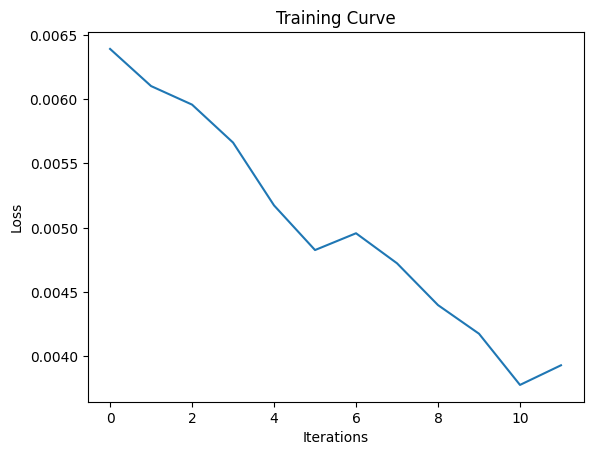

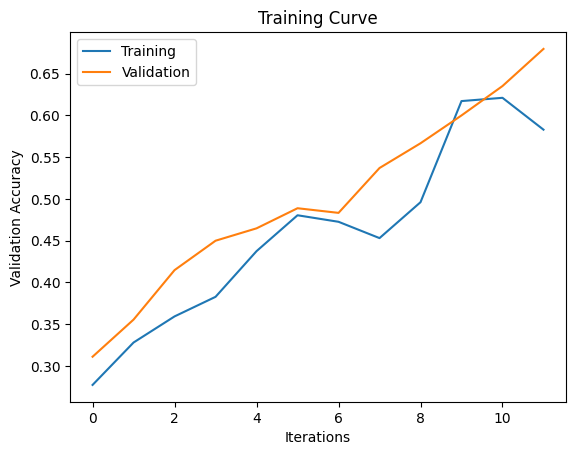

Final Training Accuracy: 0.6581112207963146
Final Validation Accuracy: 0.6796296296296296
Total time:   40.13 s  Time per Epoch:  40.13 s 


In [43]:
use_cuda = True

model = ANNClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, [], batch_size=batch_size, num_epochs=1)

The above example is only used to demonstrate the implementation of transfer learning. You are encouraged to explore different set of parameters and ways to improve the speed of the training. Note also that there is a larger dataset of flowers which you may want to try out as well to see if you can improve on the classification accuracy.

# Preventing Overfitting

In the last few weeks we discussed the idea of **overfitting**,
where a neural network model learns about the quirks of the training data,
rather than information that is generalizable to the task
at hand. We also briefly discussed idea of **underfitting**, but not in as much depth.

The reason we did not discuss underfitting much is because nowadays,
practitioners tend to avoid underfitting altogether by opting for more
powerful models. Since computation is (relatively) cheap,
and overfitting is much easier to detect, it is more straightforward
to build a high-capacity model and use known techniques to prevent
overfitting. So, always start with slightly more *capacity* than you need,
then use some of the many strategies to prevent overfitting.

We've actually already discussed several strategies for preventing overfitting:

- Use a larger training set
- Use a smaller network
- Weight-sharing (as in convolutional neural networks)
- Early stopping
- Transfer Learning

Some of these are more practical than others. For example, collecting a larger training
set may be impractical or expensive in practice. Using a smaller network means that we need
to restart training, rather than use what we already know about hyperparameters and appropriate
weights.

**Early stopping** was introduced in lab 2,
where we did not use the trained weights from the last training iteration
as our ``final'' model.
Instead, we used a model (a set of weights) from a previous
iteration of training. We chose the iteration/epoch to use based on
the training curve.

**Transfer learning** where we use pre-trained weights of a different model (e.g. AlexNet)
as part of our neural network also helps prevent overfitting.
The architectures and weights of AlexNet was trained using a larger
dataset of over a million images, and was trained to solve a different image classification problem.
Nevertheless, transfer learning allows us to leverage information
from larger data sets with low computational cost. Effectively acting like a larger training set.

These are only some of the techniques for preventing overfitting. We'll discuss more techniques today,
including:

- Data Normalization
- Data Augmentation
- Weight Decay
- Model Averaging
- Dropout

We will use the MNIST digit recognition problem as a running example. Since we are studying overfitting,
I will artificially reduce the number of training examples to 200.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# for reproducibility
torch.manual_seed(1)

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:200]     #  200 train images
mnist_val   = mnist_data[300:2300] # 2000 validation images

100%|██████████| 9912422/9912422 [00:00<00:00, 110595760.44it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34364735.84it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29526574.32it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19069598.37it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



We will also use the `MNISTClassifier` from the last few weeks as our base model:

In [46]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

And of course, our training code, with minor modifications that we will explain as we go along.

In [47]:
def train(model, train, valid, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    while True:
        if n >= num_iters:
            break
        for imgs, labels in iter(train_loader):
            model.train() #*****************************#
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            if n % 10 == 9:
                iters.append(n)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train)) # compute training accuracy
                val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            n += 1

    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Without any intervention, our model gets to about 52-53% accuracy on the validation set.

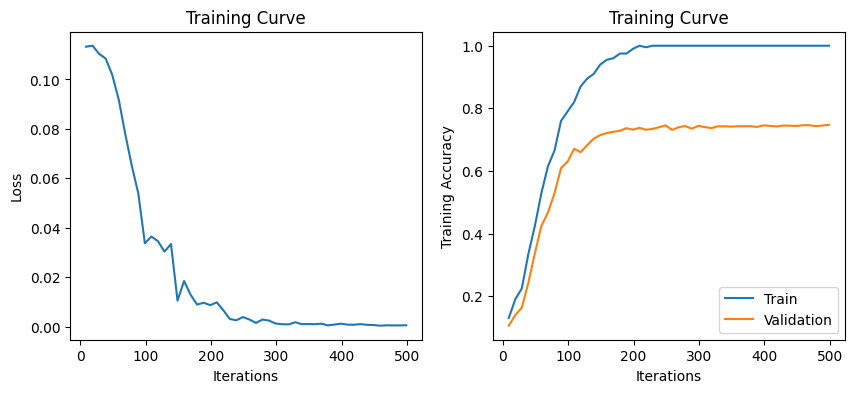

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7475


In [48]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_iters=500)

## Data Normalization

*Data normalization* means to scale the input features of a neural
network, so that all features are scaled similarly (similar means
and standard deviations). Although data normalization does not directly
prevent overfitting, normalizing your data makes the training
problem easier.

Data normalization is less of an issues for input data -- like images --
where all input features have similar interpretations.
All features of an image are pixel intensities, all of which are scaled
the same way. However, if we were performing prediction of, say,
housing prices based on a house's number of bedrooms, square footage, etc.,
we would want each of the features to be scaled similarly. A scale
of mean 0 and standard deviation 1 is one approach. Another approach
is to scale each feature so that they are in the range `[0, 1]`.

The PyTorch transform `transforms.ToTensor()` automatically scales
each pixel intensity to the range `[0, 1]`.
In your lab 2 code, we used the following transform:

In [49]:
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

This transform subtracts 0.5 from each pixel, and divides the
result by 0.5. So, each pixel intensity will be in the range `[-1, 1]`.
In general, having both positive and negative input values helps
the network trains quickly (because of the way weights are initialized).
Sticking with each pixel being in the range `[0, 1]` is usually fine.

## Data Augmentation

While it is often expensive to gather more data, we can often
programmatically *generate* more data points from our existing
data set. We can make small alterations to our training set to obtain
slightly different input data, but that is still valid.
Common ways of obtaining new (image) data include:

- Flipping each image horizontally or vertically (won't work for digit recognition, but might for other tasks)
- Shifting each pixel a little to the left or right
- Rotating the images a little
- Adding noise to the image

... or even a combination of the above. For demonstration purposes, let's randomly
rotate our digits a little to get new training samples.

Here are the 20 images in our training set:

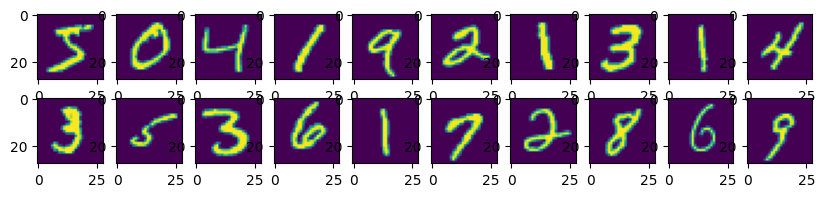

In [50]:
def show20(data):
    plt.figure(figsize=(10,2))
    for n, (img, label) in enumerate(data):
        if n >= 20:
            break
        plt.subplot(2, 10, n+1)
        plt.imshow(img)

mnist_imgs = datasets.MNIST('data', train=True, download=True)
show20(mnist_imgs)

Here are the 20 images in our training set, each rotated randomly, by up to 25 degrees.

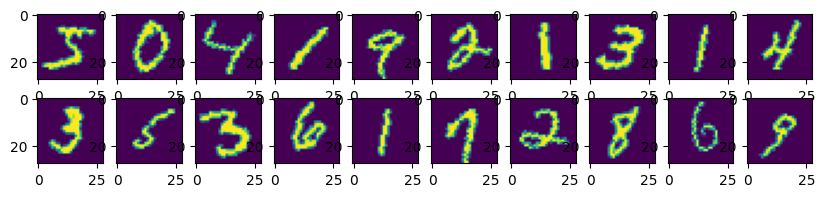

In [51]:
mnist_new = datasets.MNIST('data', train=True, download=True,
                           transform=transforms.RandomRotation(25))
show20(mnist_new)

If we apply the transformation again, we can get images with different rotations:

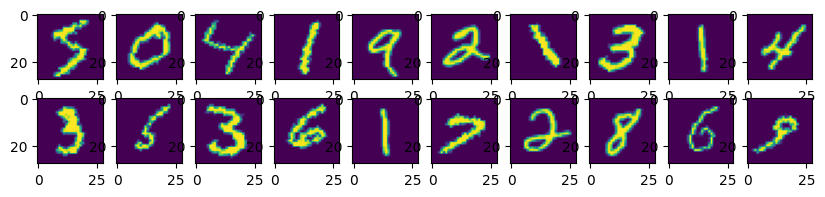

In [52]:
mnist_new = datasets.MNIST('data', train=True, download=True, transform=transforms.RandomRotation(25))
show20(mnist_new)

We can augment our data set by, say, randomly rotating each training data point 100 times:

In [53]:
augmented_train_data = []

my_transform = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ToTensor(),
])

for i in range(100):
    mnist_new = datasets.MNIST('data', train=True, download=True, transform=my_transform)
    for j, item in enumerate(mnist_new):
        if j >= 20:
            break
        augmented_train_data.append(item)

len(augmented_train_data)

2000

We obtain a better validation accuracy after training on our expanded dataset.

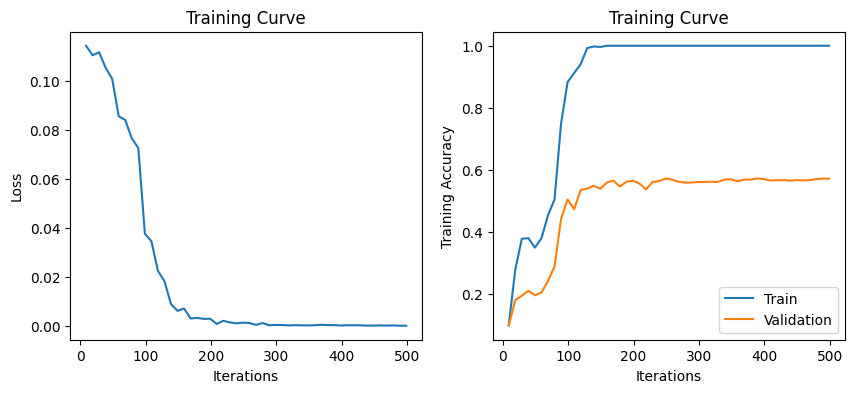

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.572


In [54]:
model = MNISTClassifier()
train(model, augmented_train_data, mnist_val, num_iters=500)

## Weight Decay

A more interesting technique that prevents overfitting is the idea of weight decay.
The idea is to **penalize large weights**. We avoid large weights, because large weights
mean that the prediction relies a lot on the content of one pixel, or on one unit. Intuitively,
it does not make sense that the classification of an image should depend heavily on the
content of one pixel, or even a few pixels.

Mathematically, we penalize large weights by adding an extra term to the loss function,
the term can look like the following:

- $L^1$ regularization: $\sum_k |w_k|$
    - Mathematically, this term encourages weights to be exactly 0
- $L^2$ regularization: $\sum_k w_k^2$
    - Mathematically, in each iteration the weight is pushed towards 0
- Combination of $L^1$ and $L^2$ regularization: add a term $\sum_k |w_k| + w_k^2$  to the loss function.

In PyTorch, weight decay can also be done automatically inside an optimizer. The parameter `weight_decay`
of `optim.SGD` and most other optimizers uses $L^2$ regularization for weight decay. The value of the
`weight_decay` parameter is another tunable hyperparameter.

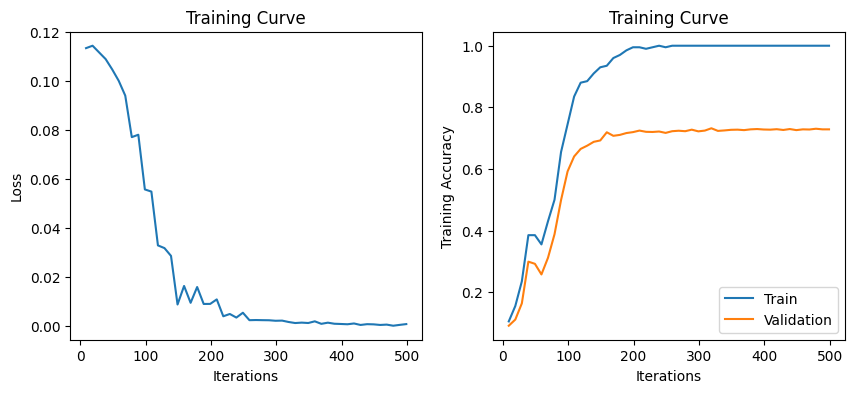

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7285


In [55]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_iters=500, weight_decay=0.001)

## Dropout

Yet another way to prevent overfitting is to build **many** models, then average
their predictions at test time. Each model might have a different set of
initial weights.

We won't show an example of model averaging here. Instead, we will show another
idea that sounds drastically different on the surface.

This idea is called **dropout**: we will randomly "drop out", "zero out", or "remove" a portion
of neurons from each training iteration.

![](imgs/dropout.png)

In different iterations of training, we will drop out a different set of neurons.

The technique has an effect of preventing weights from being overly dependent on
each other: for example for one weight to be unnecessarily large to compensate for
another unnecessarily large weight with the opposite sign. Weights are encouraged
to be "more independent" of one another.

During test time though, we will not drop out any neurons; instead we will use
the entire set of weights. This means that our training time and test time behaviour
of dropout layers are *different*. In the code for the function `train` and `get_accuracy`,
we use `model.train()` and `model.eval()` to flag whether we want the model's training behaviour,
or test time behaviour.

While unintuitive, using all connections is a form
of model averaging! We are effectively averaging over many different networks
of various connectivity structures.

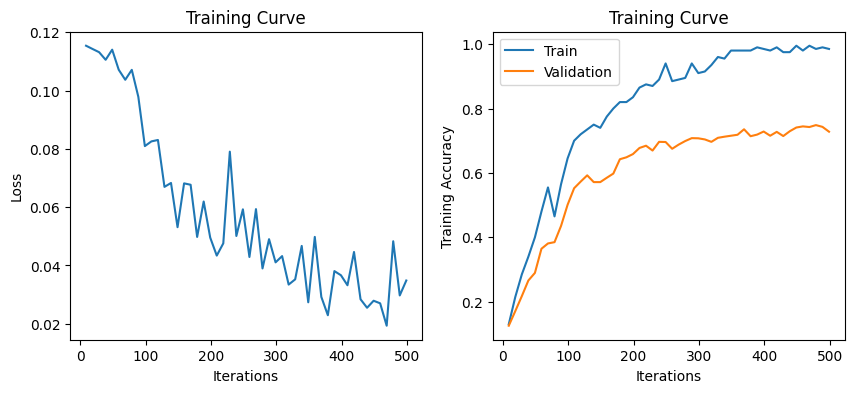

Final Training Accuracy: 0.985
Final Validation Accuracy: 0.728


In [56]:
class MNISTClassifierWithDropout(nn.Module):
    def __init__(self):
        super(MNISTClassifierWithDropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(0.4) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(self.dropout1(flattened)))
        activation2 = F.relu(self.layer2(self.dropout2(activation1)))
        output = self.layer3(self.dropout3(activation2))
        return output

model = MNISTClassifierWithDropout()
train(model, mnist_train, mnist_val, num_iters=500)